# Importing packages

In [30]:
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from stepbystep.v0 import StepByStep
from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from plots.chapter5 import plot_images

# Concept experiments

In [2]:
image_mat = np.array(
    [[[
        [1, 5, 6, 8, 11, 2],
        [2, 5, 6, 8, 9, 3],
        [0, 3, 16, 24, 2, 8],
        [10, 21, 4, 69, 2, 3],
        [33, 25, 5, 8, 9, 11],
        [3, 8, 9, 3, 4, 7]
    ]]]
)

image_mat.shape

(1, 1, 6, 6)

In [3]:
filter_mat = np.array(
    [[[
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]]]
)

filter_mat.shape

(1, 1, 3, 3)

In [6]:
image_tensor = torch.as_tensor(image_mat).float()
filter_tensor = torch.as_tensor(filter_mat).float()

concolved = F.conv2d(image_tensor, filter_tensor, stride=1)
concolved

tensor([[[[ 5.,  6.,  8.,  9.],
          [ 3., 16., 24.,  2.],
          [21.,  4., 69.,  2.],
          [25.,  5.,  8.,  9.]]]])

In [7]:
conv = nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=3, stride=1
)

conv(image_tensor)

tensor([[[[ -4.9234,  -9.3491,  -7.3900,  -7.7206],
          [ -6.0504, -27.8258, -10.3816, -18.9732],
          [-16.9247,  -5.8056,  -5.2243,  -1.2503],
          [ -0.1438,  -5.3850,   9.9900,   3.3429]]]],
       grad_fn=<ConvolutionBackward0>)

In [9]:
conv_multi = nn.Conv2d(
    in_channels=1, out_channels=2, kernel_size=3, stride=1
)

conv_multi.weight

Parameter containing:
tensor([[[[-0.2542,  0.0047, -0.1818],
          [-0.1648, -0.0099, -0.1213],
          [ 0.2483, -0.1855, -0.2277]]],


        [[[ 0.1880, -0.0903,  0.1902],
          [-0.0716,  0.3158,  0.2549],
          [ 0.0767,  0.1675,  0.1331]]]], requires_grad=True)

In [10]:
with torch.no_grad():
    conv.weight[0] = filter_tensor
    conv.bias[0] = 0

conv(image_tensor)

tensor([[[[ 5.,  6.,  8.,  9.],
          [ 3., 16., 24.,  2.],
          [21.,  4., 69.,  2.],
          [25.,  5.,  8.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [11]:
conv_pad = nn.ConstantPad2d(padding=1, value=0)
padded_image = conv_pad(image_tensor)
padded_image

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  5.,  6.,  8., 11.,  2.,  0.],
          [ 0.,  2.,  5.,  6.,  8.,  9.,  3.,  0.],
          [ 0.,  0.,  3., 16., 24.,  2.,  8.,  0.],
          [ 0., 10., 21.,  4., 69.,  2.,  3.,  0.],
          [ 0., 33., 25.,  5.,  8.,  9., 11.,  0.],
          [ 0.,  3.,  8.,  9.,  3.,  4.,  7.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [13]:
f_pad = F.pad(image_tensor, pad=(1, 1, 1, 1), mode='constant', value=0)
f_pad

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  5.,  6.,  8., 11.,  2.,  0.],
          [ 0.,  2.,  5.,  6.,  8.,  9.,  3.,  0.],
          [ 0.,  0.,  3., 16., 24.,  2.,  8.,  0.],
          [ 0., 10., 21.,  4., 69.,  2.,  3.,  0.],
          [ 0., 33., 25.,  5.,  8.,  9., 11.,  0.],
          [ 0.,  3.,  8.,  9.,  3.,  4.,  7.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [14]:
conv_rep_pad = nn.ReplicationPad2d(padding=1)
conv_rep_pad(image_tensor)

tensor([[[[ 1.,  1.,  5.,  6.,  8., 11.,  2.,  2.],
          [ 1.,  1.,  5.,  6.,  8., 11.,  2.,  2.],
          [ 2.,  2.,  5.,  6.,  8.,  9.,  3.,  3.],
          [ 0.,  0.,  3., 16., 24.,  2.,  8.,  8.],
          [10., 10., 21.,  4., 69.,  2.,  3.,  3.],
          [33., 33., 25.,  5.,  8.,  9., 11., 11.],
          [ 3.,  3.,  8.,  9.,  3.,  4.,  7.,  7.],
          [ 3.,  3.,  8.,  9.,  3.,  4.,  7.,  7.]]]])

In [15]:
f_rep_pad = F.pad(image_tensor, pad=(1, 1, 1, 1), mode='replicate')
f_rep_pad

tensor([[[[ 1.,  1.,  5.,  6.,  8., 11.,  2.,  2.],
          [ 1.,  1.,  5.,  6.,  8., 11.,  2.,  2.],
          [ 2.,  2.,  5.,  6.,  8.,  9.,  3.,  3.],
          [ 0.,  0.,  3., 16., 24.,  2.,  8.,  8.],
          [10., 10., 21.,  4., 69.,  2.,  3.,  3.],
          [33., 33., 25.,  5.,  8.,  9., 11., 11.],
          [ 3.,  3.,  8.,  9.,  3.,  4.,  7.,  7.],
          [ 3.,  3.,  8.,  9.,  3.,  4.,  7.,  7.]]]])

In [16]:
conv_ref_pad = nn.ReflectionPad2d(padding=1)
conv_ref_pad(image_tensor)

tensor([[[[ 5.,  2.,  5.,  6.,  8.,  9.,  3.,  9.],
          [ 5.,  1.,  5.,  6.,  8., 11.,  2., 11.],
          [ 5.,  2.,  5.,  6.,  8.,  9.,  3.,  9.],
          [ 3.,  0.,  3., 16., 24.,  2.,  8.,  2.],
          [21., 10., 21.,  4., 69.,  2.,  3.,  2.],
          [25., 33., 25.,  5.,  8.,  9., 11.,  9.],
          [ 8.,  3.,  8.,  9.,  3.,  4.,  7.,  4.],
          [25., 33., 25.,  5.,  8.,  9., 11.,  9.]]]])

In [17]:
f_ref_pad = F.pad(image_tensor, pad=(1, 1, 1, 1), mode='reflect')
f_ref_pad

tensor([[[[ 5.,  2.,  5.,  6.,  8.,  9.,  3.,  9.],
          [ 5.,  1.,  5.,  6.,  8., 11.,  2., 11.],
          [ 5.,  2.,  5.,  6.,  8.,  9.,  3.,  9.],
          [ 3.,  0.,  3., 16., 24.,  2.,  8.,  2.],
          [21., 10., 21.,  4., 69.,  2.,  3.,  2.],
          [25., 33., 25.,  5.,  8.,  9., 11.,  9.],
          [ 8.,  3.,  8.,  9.,  3.,  4.,  7.,  4.],
          [25., 33., 25.,  5.,  8.,  9., 11.,  9.]]]])

In [18]:
f_cir_pad = F.pad(image_tensor, pad=(1, 1, 1, 1), mode='circular')
f_cir_pad

tensor([[[[ 7.,  3.,  8.,  9.,  3.,  4.,  7.,  3.],
          [ 2.,  1.,  5.,  6.,  8., 11.,  2.,  1.],
          [ 3.,  2.,  5.,  6.,  8.,  9.,  3.,  2.],
          [ 8.,  0.,  3., 16., 24.,  2.,  8.,  0.],
          [ 3., 10., 21.,  4., 69.,  2.,  3., 10.],
          [11., 33., 25.,  5.,  8.,  9., 11., 33.],
          [ 7.,  3.,  8.,  9.,  3.,  4.,  7.,  3.],
          [ 2.,  1.,  5.,  6.,  8., 11.,  2.,  1.]]]])

In [20]:
conv_image = F.conv2d(f_cir_pad, filter_tensor, stride=1)
conv_image

tensor([[[[ 1.,  5.,  6.,  8., 11.,  2.],
          [ 2.,  5.,  6.,  8.,  9.,  3.],
          [ 0.,  3., 16., 24.,  2.,  8.],
          [10., 21.,  4., 69.,  2.,  3.],
          [33., 25.,  5.,  8.,  9., 11.],
          [ 3.,  8.,  9.,  3.,  4.,  7.]]]])

In [21]:
pooled_image = F.max_pool2d(conv_image, kernel_size=2)
pooled_image

tensor([[[[ 5.,  8., 11.],
          [21., 69.,  8.],
          [33.,  9., 11.]]]])

In [22]:
nn_pool = nn.MaxPool2d(kernel_size=4)
nn_pool(conv_image)

tensor([[[[69.]]]])

In [23]:
pooled_image2 = F.avg_pool2d(conv_image, kernel_size=3, stride=1)
pooled_image2

tensor([[[[ 4.8889,  9.0000, 10.0000,  8.3333],
          [ 7.4444, 17.3333, 15.5556, 14.2222],
          [13.0000, 19.4444, 15.4444, 15.1111],
          [13.1111, 16.8889, 12.5556, 12.8889]]]])

In [26]:
nn_pool = nn.AvgPool2d(kernel_size=4, stride=1)
nn_pool(conv_image)

tensor([[[[11.7500, 12.4375, 11.3125],
          [14.9375, 13.5000, 11.6875],
          [15.0625, 13.2500, 11.5000]]]])

In [27]:
nn.Flatten()(pooled_image)

tensor([[ 5.,  8., 11., 21., 69.,  8., 33.,  9., 11.]])

In [28]:
pooled_image.view(1, -1)

tensor([[ 5.,  8., 11., 21., 69.,  8., 33.,  9., 11.]])

# Multiclass classification

In [29]:
images, labels = generate_dataset(
    img_size=10, n_images=1000, binary=False, seed=17
)

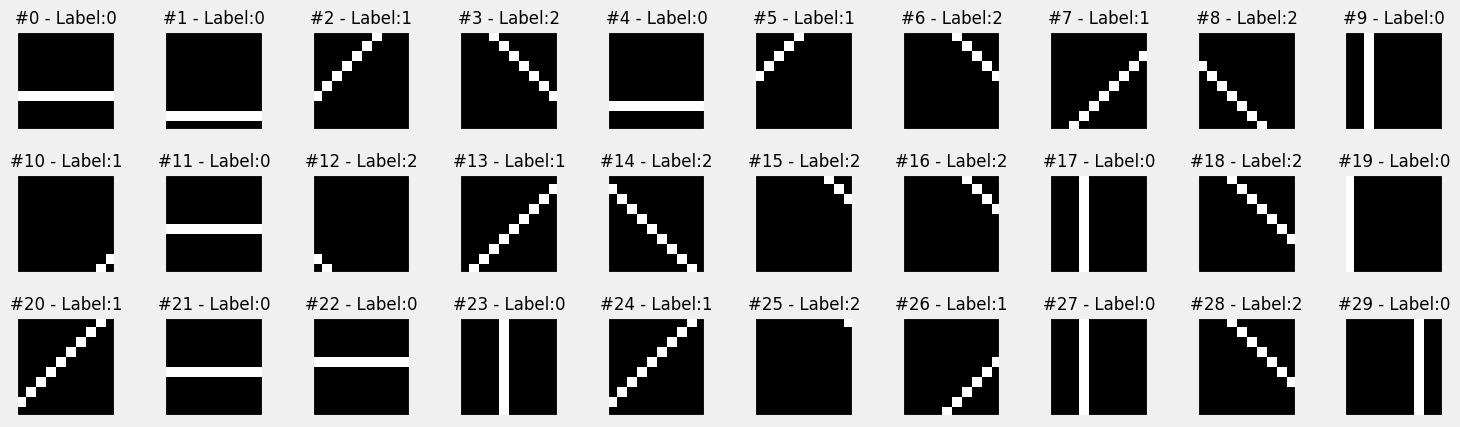

In [32]:
fig = plot_images(images, labels, n_plot=30)

## Data preparation

In [34]:
class TransformedTensorDataset(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x[idx]

        if self.transform:
            x = self.transform(x)

        return x, self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [36]:
X_tensor = torch.as_tensor(images/255).float()
y_tensor = torch.as_tensor(labels).long()

train_idx, val_idx = index_splitter(len(X_tensor), [80, 20])

X_train_tensor = X_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

X_val_tensor = X_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_composer = Compose([
    Normalize(mean=(0.5,), std=(0.5,))
])

val_composer = Compose([
    Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = TransformedTensorDataset(X_train_tensor, y_train_tensor, train_composer)
val_dataset = TransformedTensorDataset(X_val_tensor, y_val_tensor, val_composer)

sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)